In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [2]:
#baseline test
results_path = r's3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_100ms_20251022_190159/'

In [16]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.parquet"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.scan_parquet(session_table_path).collect()

dr_session_list=(
    session_table.filter(
    pl.col('project').eq("DynamicRouting"),
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues').eq([]),
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )


In [18]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [19]:

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        # pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
        pl.col('trial_indices').alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba').mean(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                #iti column?
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

In [ ]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()


In [ ]:
np.vstack(predict_proba_pd.query('structure=="ACAd"').sort_values(['bin_center'])['predict_proba'].values).T

array([[0.78184979, 0.85827466, 0.09206538, ..., 0.99895092, 0.51732567,
        0.91514763],
       [0.90096548, 0.45676105, 0.22825049, ..., 0.61501621, 0.98179183,
        0.90549652],
       [0.04134444, 0.74453868, 0.10841109, ..., 0.04114314, 0.04105991,
        0.01785469],
       ...,
       [0.81091859, 0.93347162, 0.96866164, ..., 0.75758931, 0.92759704,
        0.29815863],
       [0.68609134, 0.21679501, 0.71842271, ..., 0.25483994, 0.92147801,
        0.87346655],
       [0.96421057, 0.99477465, 0.12899018, ..., 0.87357395, 0.99966741,
        0.96295148]])

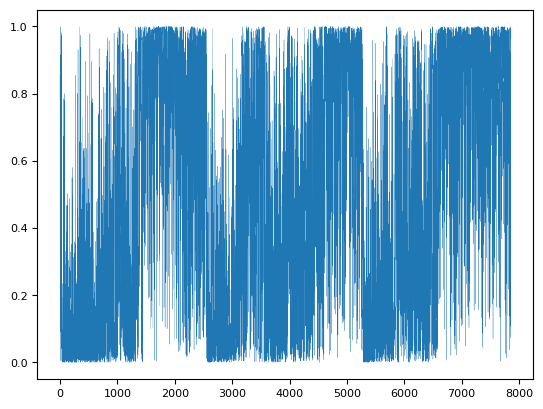

In [32]:
test_vector=np.vstack(predict_proba_pd.query('structure=="ACAd"').sort_values(['bin_center'])['predict_proba'].values).T
test_vector=test_vector.flatten()

fig,ax=plt.subplots()
# ax.plot(np.nanmean(test_vector,axis=0))
ax.plot(test_vector,linewidth=0.2)

In [21]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()#.to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect()#.to_pandas()

Text(0.5, 1.0, 'Pearson r=0.436, p=0.000e+00')

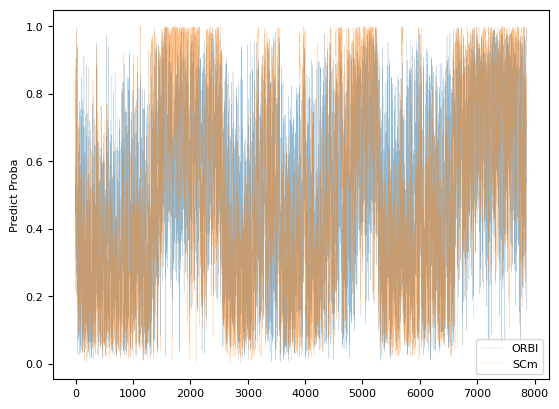

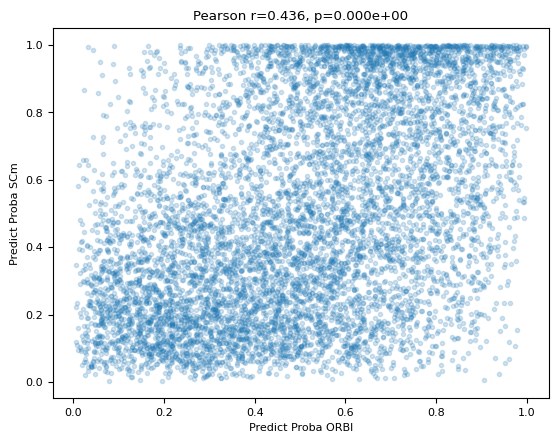

In [42]:
struct1='ORBl'
struct2='SCm'

predict_proba_struct1=np.vstack(predict_proba_pd.query(f'structure=="{struct1}"').sort_values(['bin_center'])['predict_proba'].values).T
predict_proba_struct1=predict_proba_struct1.flatten()

predict_proba_struct2=np.vstack(predict_proba_pd.query(f'structure=="{struct2}"').sort_values(['bin_center'])['predict_proba'].values).T
predict_proba_struct2=predict_proba_struct2.flatten()

fig,ax=plt.subplots()
ax.plot(predict_proba_struct1,linewidth=0.2,alpha=0.5,label=struct1)
ax.plot(predict_proba_struct2,linewidth=0.2,alpha=0.5,label=struct2)
ax.set_ylabel('Predict Proba')
ax.legend()


r,p=stats.pearsonr(predict_proba_struct1, predict_proba_struct2)

fig,ax=plt.subplots()
ax.plot(predict_proba_struct1, predict_proba_struct2,linewidth=0.2,marker='.',linestyle='none',alpha=0.2)
ax.set_xlabel(f'Predict Proba {struct1}')
ax.set_ylabel(f'Predict Proba {struct2}')
ax.set_title(f'Pearson r={r:.3f}, p={p:.3e}')